##### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Hourly, Point
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.manifold import TSNE

### What is clustering and how does it work?

Clustering is a technique in we can uncover hidden patterns within a data, it aims to partition the data such that observations which are most similar are grouped together. It is an unsupervised technique which does not require a target or label. There are many different clustering algorithms, which work for certain kinds of data. For example, KMeans clustering works well for low-dimension numerical data. K-means uses a user defined number of clusters/centroids (k). It picks k random points in the data, and calculates the euclidean distances of each datapoint assigning each datapoint to the corresponding centroid with the minimum distance. During training, k-means iteratively changes centroid location based on the calculated mean for that cluster, and recalculates the distances reassigning the datapoints based on the minimum distance until the centroids no longer change. It is important to note that there are clustering algorithms which can use different types of distances including Manhattan, Hamming, Levenshtein, etc.

### Data Introduction

The dataset that I will be working with for this project comes from the open data portal from the city of Charlotte, North Carolina. This dataset contains about 500,000 records of car accidents in Charlotte and within Mecklenburg county beginning in the year 2010. The data contains several features including latitude and longitude coordinates, crash severity with description, crash type, and date of the accident. My original plan for this project was to expand this dataset by adding weather features which include parameters such as, rain level, fog, dew point, and snow levels. 

### Data Understanding/Visualization

For visualizing the data, one of the simplest and most important visualizations are boxplots, and pairplots. However, since this dataset is mostly categorical I will only visualize the crash type across all levels of crash severity. The barplot below shows a glimpse of the distribution of crash type, and we can see that the most common accidents are "rear end" which cause "property damage". I expect this to have a significant influence in the clustering models.

In [2]:
df = pd.read_csv("Crashes.csv")
df.head(5)

,X,Y,OBJECTID,CRSH_ID,DATE_VAL,DATE_VAL_YEAR,DATE_VAL_MONTH,DATE_VAL_MONTH_DESC,DATE_VAL_DAY,DAY_OF_WEEK,DAY_OF_WEEK_DESC,MILT_TIME,CASE_NUM,CRSH_TYPE_CD,CRASH_TYPE,CRSH_LEVL,CRSH_LEVL_DESC,LATITUDE,LONGITUDE
0,1.459633e+06,574471.294491,1,638521,2013/07/26 04:00:00+00,2013,7,July,26,6,Friday,2206,20130726220601,6,crossed centerline,4.0,Possible Injury,35.314918,-80.811518
1,1.485534e+06,569680.825398,2,638525,2013/07/27 04:00:00+00,2013,7,July,27,7,Saturday,136,20130727013600,3,Ran off road straight ahead,5.0,Property Damage,35.303025,-80.724429
2,1.453856e+06,540117.288725,3,638526,2013/07/27 04:00:00+00,2013,7,July,27,7,Saturday,215,20130727021701,14,Pedestrian,5.0,Property Damage,35.220250,-80.828762
3,1.433454e+06,551124.237839,4,638528,2013/07/27 04:00:00+00,2013,7,July,27,7,Saturday,245,20130727024500,29,Sideswipe; opposite direction,5.0,Property Damage,35.249436,-80.897764
4,1.432444e+06,510347.904366,5,638529,2013/07/27 04:00:00+00,2013,7,July,27,7,Saturday,436,20130727043600,1,Ran off road right,5.0,Property Damage,35.137363,-80.898534


In [3]:
df.describe()

,X,Y,OBJECTID,CRSH_ID,DATE_VAL_YEAR,DATE_VAL_MONTH,DATE_VAL_DAY,DAY_OF_WEEK,MILT_TIME,CASE_NUM,CRSH_TYPE_CD,CRSH_LEVL,LATITUDE,LONGITUDE
count,4.980590e+05,4.980590e+05,498059.000000,4.980590e+05,498059.000000,498059.000000,498059.000000,498059.000000,498059.000000,4.980590e+05,498059.000000,497841.000000,497950.000000,497950.000000
mean,1.454282e+06,5.411948e+05,249030.000000,9.346851e+05,2018.421265,6.584180,15.644863,4.125122,1374.206046,2.018946e+13,22.368091,4.672699,35.223210,-80.827386
std,2.179646e+04,3.048497e+04,143777.393199,2.455260e+05,4.098365,3.487758,8.755815,1.907679,527.489153,2.861083e+12,7.880762,0.610072,0.083866,0.072944
min,4.367008e+05,-3.076535e+05,1.000000,4.468660e+05,2010.000000,1.000000,1.000000,1.000000,0.000000,7.337250e+05,0.000000,1.000000,32.900601,-84.170967
25%,1.440059e+06,5.226996e+05,124515.500000,7.336410e+05,2015.000000,4.000000,8.000000,3.000000,1017.000000,2.015102e+13,21.000000,4.000000,35.172080,-80.874957
50%,1.452655e+06,5.403939e+05,249030.000000,9.340080e+05,2019.000000,7.000000,16.000000,4.000000,1435.000000,2.019022e+13,21.000000,5.000000,35.221193,-80.832746
75%,1.470400e+06,5.584712e+05,373544.500000,1.166216e+06,2022.000000,10.000000,23.000000,6.000000,1747.000000,2.022072e+13,28.000000,5.000000,35.270940,-80.772558
max,4.184414e+06,3.321195e+06,498059.000000,2.244283e+06,2025.000000,12.000000,31.000000,7.000000,2359.000000,2.019071e+15,99.000000,6.000000,42.802414,-70.957126


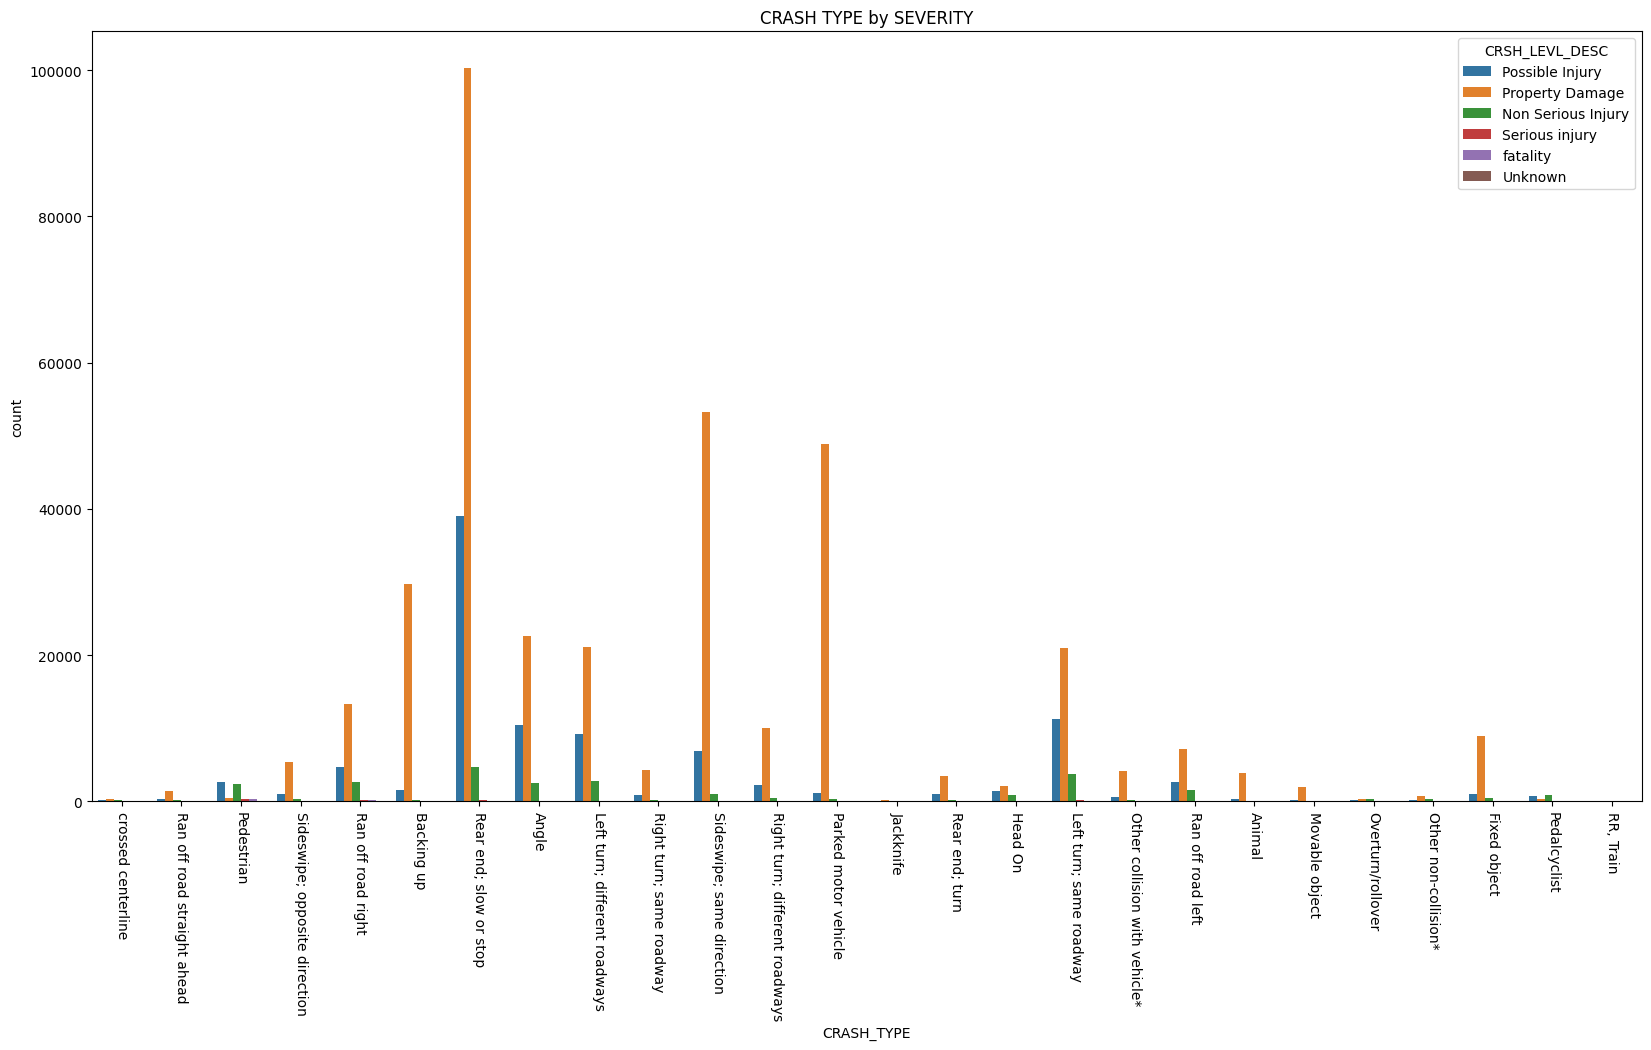

In [4]:
plt.figure(figsize=(20,10))
sns.countplot(df, x='CRASH_TYPE',hue='CRSH_LEVL_DESC')
plt.title('CRASH TYPE by SEVERITY')
plt.xticks(rotation=-90)
plt.show()

### Pre-processing data

To preprocess the data, I always begin by assessing the Null value counts, the duplicated row counts, and the column data types. In this case there are no diplicated rows, however theres quite a few rows which may have several null values. I will be dropping these values since they are only a small proportion compared to the full dataset.

In [5]:
print("Duplicated rows: ", df.duplicated().sum())
print("Nulls: ",df.isna().sum())
print("Data types: ", df.info())
df = df.dropna()

Duplicated rows:  0
Nulls:  X                         0
Y                         0
OBJECTID                  0
CRSH_ID                   0
DATE_VAL                  0
DATE_VAL_YEAR             0
DATE_VAL_MONTH            0
DATE_VAL_MONTH_DESC       0
DATE_VAL_DAY              0
DAY_OF_WEEK               0
DAY_OF_WEEK_DESC          0
MILT_TIME                 0
CASE_NUM                  0
CRSH_TYPE_CD              0
CRASH_TYPE             3269
CRSH_LEVL               218
CRSH_LEVL_DESC          218
LATITUDE                109
LONGITUDE               109
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498059 entries, 0 to 498058
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   X                    498059 non-null  float64
 1   Y                    498059 non-null  float64
 2   OBJECTID             498059 non-null  int64  
 3   CRSH_ID              498059 non-null  int64  
 4   DATE_

After assessing the data types, I see that there are several categorical variables which are not inherently good for clustering. This was one of my worries when I chose this dataset because categorical values do not work well with KMeans, more specifically Euclidean Distances which several clustering algorithms rely on. There are several ways to work with categorical data for clustering, one of them being generating vector embeddings from which we can represent the data as numerical vectors. We can also attempt to do one-hot-encoding however this has several drawbacks. The main issue with one-hot-encoding is dimensionality explosion, and also resulting in the addition of sparse features to the dataset. For this project, I chose to drop most categorical features and keep only the CRASH_TYPE which I will be one-hot-encoding for simplicity. I also chose to keep CRASH_LEVEL which is an ordinal feature that I will be scaling along with the rest of the features by using a MinMaxScaler

In [6]:
categorical = [col for col in df.columns if df[col].dtype == 'object' and col not in ['CRASH_TYPE','CRSH_LEVL_DESC']]
df = df.drop(columns=categorical)

## dropping other non-descriptive features
df = df.drop(columns=['CRSH_ID', 'OBJECTID', 'CASE_NUM', 'CRSH_TYPE_CD'])

In [7]:
def parse_time(data: pd.DataFrame):
    time = data['MILT_TIME'].astype(str).str.zfill(4)
    df['HOUR'] = time.str[:2].astype(int)
    df['MINUTE'] = time.str[2:].astype(int)
    return data

def encode_cyclical(data: pd.DataFrame, columns: list):

    for column in columns:
        if column in data.columns:
            data[column + "_sin"] = np.sin(2 * np.pi * data[column]/np.max(data[column]))
            data[column + "_cos"] = np.cos(2 * np.pi * data[column]/np.max(data[column]))
        else:
            print(f"Could not encode column: {column}")
    return data

In [8]:
## parsing the military time and adding a datetime object for later use
df = parse_time(df)

df['DATE_TIME'] = pd.to_datetime({
    'year': df['DATE_VAL_YEAR'],
    'month': df['DATE_VAL_MONTH'],
    'day': df['DATE_VAL_DAY'],
    'hour': df['HOUR']
})
df = df.drop(columns='MILT_TIME')

I plan to add local weather data to this project by using a library called Meteostat from which I can request weather data for a specific time frame, coordinate point and weather station. After doing some research, there arent many weather stations in Charlotte, thus I opted to use the default which would be the closest to the specific coordinate point. Since the requested weather data is likely to come from a single weather station in Charlotte, I have opted to use an averaged latitude and longitude coordinate along with the earliest date and most recent date which means I can use a single request for all the data needed.

In [9]:
dates = df[['DATE_TIME']].drop_duplicates()
avg_lat = df['LATITUDE'].mean()
avg_lon = df['LONGITUDE'].mean()

location = Point(lat=avg_lat, lon=avg_lon)
weather_data = Hourly(location, start=dates['DATE_TIME'].min(), end=dates['DATE_TIME'].max()).fetch()
weather_data = weather_data.fillna(0)
zero_cols = weather_data.columns[(weather_data == 0.0).all()]
weather_data = weather_data.drop(columns=zero_cols)
weather_data.head()

,temp,dwpt,rhum,prcp,wdir,wspd,wpgt,pres,coco
time,,,,,,,,,
2010-01-01 00:00:00,6.1,5.7,97.0,0.0,0.0,0.0,0.0,1017.5,0.0
2010-01-01 01:00:00,6.1,5.7,97.0,0.0,0.0,0.0,0.0,1017.6,0.0
2010-01-01 02:00:00,6.1,5.7,97.0,0.0,0.0,0.0,0.0,1017.5,0.0
2010-01-01 03:00:00,6.1,5.7,97.0,0.0,0.0,0.0,0.0,1017.2,0.0
2010-01-01 04:00:00,6.1,5.7,97.0,0.0,0.0,0.0,0.0,1017.2,0.0


##### Merging Weather Data to Accident Data

In [10]:
df = df.merge(weather_data, how='left', left_on='DATE_TIME', right_on='time')
df.head()

,X,Y,DATE_VAL_YEAR,DATE_VAL_MONTH,DATE_VAL_DAY,DAY_OF_WEEK,CRASH_TYPE,CRSH_LEVL,CRSH_LEVL_DESC,LATITUDE,...,DATE_TIME,temp,dwpt,rhum,prcp,wdir,wspd,wpgt,pres,coco
0,1.459633e+06,574471.294491,2013,7,26,6,crossed centerline,4.0,Possible Injury,35.314918,...,2013-07-26 22:00:00,29.4,18.8,53.0,0.0,160.0,11.2,0.0,1016.4,0.0
1,1.485534e+06,569680.825398,2013,7,27,7,Ran off road straight ahead,5.0,Property Damage,35.303025,...,2013-07-27 01:00:00,26.1,19.5,67.0,0.0,170.0,11.2,0.0,1016.7,0.0
2,1.453856e+06,540117.288725,2013,7,27,7,Pedestrian,5.0,Property Damage,35.220250,...,2013-07-27 02:00:00,26.1,20.0,69.0,0.0,130.0,13.0,0.0,1016.7,0.0
3,1.433454e+06,551124.237839,2013,7,27,7,Sideswipe; opposite direction,5.0,Property Damage,35.249436,...,2013-07-27 02:00:00,26.1,20.0,69.0,0.0,130.0,13.0,0.0,1016.7,0.0
4,1.432444e+06,510347.904366,2013,7,27,7,Ran off road right,5.0,Property Damage,35.137363,...,2013-07-27 04:00:00,25.0,19.4,71.0,0.0,140.0,14.8,0.0,1017.0,0.0


##### Encoding Cyclical Features and One-Hot-Encoding

In [11]:
df = encode_cyclical(df, ['DATE_VAL_YEAR', 'DATE_VAL_MONTH', 'DATE_VAL_DAY','DAY_OF_WEEK', 'HOUR', 'MINUTE'])

In [12]:
crash_dummies = pd.get_dummies(df['CRASH_TYPE'], dtype=float)

##### Dimensionality Reduction

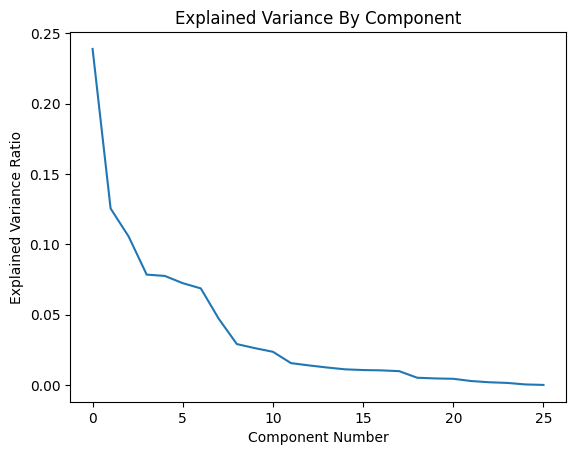

In [13]:
svd = TruncatedSVD(n_components=26, random_state=42)
svd.fit(crash_dummies)
plt.plot(svd.explained_variance_ratio_) 

plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance By Component')

plt.show()

In [13]:
svd = TruncatedSVD(n_components = 7, random_state = 42)
svd_columns = [f'svd_{i}' for i in range(7)]
svd_dummies = pd.DataFrame(svd.fit_transform(crash_dummies), columns=svd_columns)
svd_dummies.head()

,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6
0,7.310266e-15,-4.429368e-13,-3.291385e-12,-1.643819e-10,1.161949e-10,1.807307e-10,5.288951e-10
1,6.066024e-12,8.354359e-11,8.224616e-10,2.012098e-09,-1.430585e-08,-2.100985e-08,-1.593824e-08
2,2.989914e-11,2.136773e-09,-6.465894e-09,6.435830e-08,2.629148e-08,-1.482673e-07,-1.047395e-07
3,-6.068848e-11,-4.377776e-09,1.328525e-08,-1.321579e-07,-5.534325e-08,3.061627e-07,2.140458e-07
4,-5.025108e-13,-4.399608e-11,1.465677e-10,-1.900040e-09,-8.076706e-10,4.932451e-09,3.775612e-09


##### Feature Standardization

In [14]:
numeric_feats = ['X','Y', 'CRSH_LEVL']
weather_feats = weather_data.columns
droppers = ['CRASH_TYPE', 'CRSH_LEVL_DESC', 'HOUR','MINUTE','LATITUDE','LONGITUDE', 'DATE_TIME', 'DATE_VAL_YEAR', 'DATE_VAL_MONTH','DATE_VAL_DAY', 'DAY_OF_WEEK']

scaler = MinMaxScaler()
standardized_df = df.drop(columns=droppers)
standardized_df[numeric_feats] = scaler.fit_transform(df[numeric_feats])
standardized_df[weather_feats] = scaler.fit_transform(df[weather_feats])
standardized_df = pd.concat([standardized_df, svd_dummies], axis=1)

### Modeling

For this project, I would have liked to train several different methods for modeling including KMeans, and HDBSCAN. While KMeans is not an optimal algorithm for categorical or sparse datasets such as the one im currently working with, it is a very fast algorithm relative to other clustering techniques thus I was able to run it on my laptop with no issues. However, since HDBSCAN can have a worst case complexity of $O(n^{2})$ it does not run well for me.

Text(0, 0.5, 'Inertia')

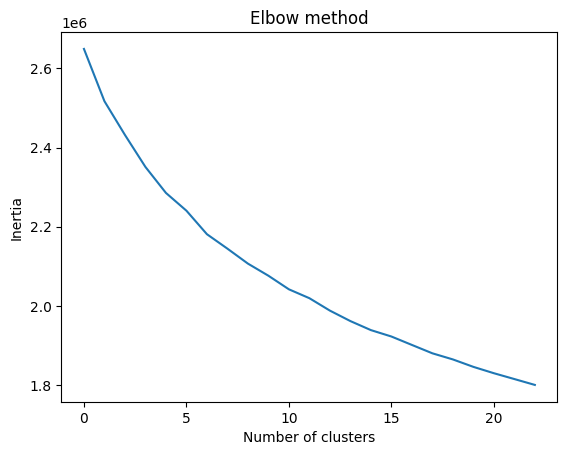

In [16]:
intertias = []

# Loop through different possible numbers of clusters
for i in range(2,25):
    kmeans = KMeans(i, random_state=5)
    clusters = kmeans.fit_predict(standardized_df)
    intertias.append(kmeans.inertia_)


#Plotting the inertia values against no. of clusters
plt.plot(intertias)
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [15]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(standardized_df)
standardized_df['CLUSTERS'] = kmeans.predict(standardized_df)
df['CLUSTERS'] = kmeans.labels_

### Storytelling Cluster Analysis

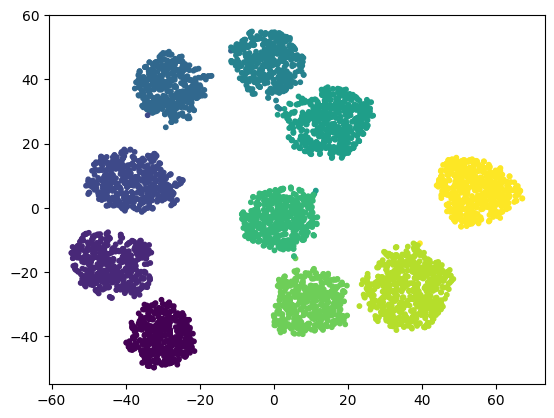

In [16]:
sampled_df = standardized_df.sample(5000,random_state=42)
tsne = TSNE(n_components=2, random_state=42, perplexity=50.0).fit_transform(sampled_df)
plt.scatter(tsne[:,0], tsne[:,1], c=sampled_df['CLUSTERS'], cmap='viridis', s=10)
plt.show()

In [22]:
print("CLUSTER SIZES: ",df['CLUSTERS'].value_counts().sort_index())

for k in range(10):
    print(f'=================Custer: {k}======================')
    sample = df[df['CLUSTERS']==k]
    print(f"Average Temperature: {sample['temp'].mean():.2f} C")
    print(f"Average Precipitation: {sample['prcp'].mean():.2f} mm")
    print(f"Day of Week (TOP3): ", sample['DAY_OF_WEEK'].value_counts().head(3))
    print(f"HOUR of DAY (TOP3): ", sample['HOUR'].value_counts().head(3))
    print("CRASH TYPE (TOP3): ", sample['CRASH_TYPE'].value_counts().head(3))
    print("CRASH SEVERITY (TOP3): ", sample['CRSH_LEVL_DESC'].value_counts().head(3))
    print('===================================================')
    print('\n')
    


CLUSTER SIZES:  CLUSTERS
0    46822
1    49299
2    52106
3    44735
4    45270
5    51475
6    43062
7    50991
8    58281
9    52427
Name: count, dtype: int64
=================Custer: 0======================
Average Temperature: 13.12 C
Average Precipitation: 0.16 mm
Day of Week (TOP3):  DAY_OF_WEEK
3    13271
4    13033
2    11504
Name: count, dtype: int64
HOUR of DAY (TOP3):  HOUR
8    8973
7    8400
9    6755
Name: count, dtype: int64
CRASH TYPE (TOP3):  CRASH_TYPE
Rear end; slow or stop       14277
Sideswipe; same direction     6178
Parked motor vehicle          4800
Name: count, dtype: int64
CRASH SEVERITY (TOP3):  CRSH_LEVL_DESC
Property Damage       34795
Possible Injury        9560
Non Serious Injury     2257
Name: count, dtype: int64


=================Custer: 1======================
Average Temperature: 13.80 C
Average Precipitation: 0.12 mm
Day of Week (TOP3):  DAY_OF_WEEK
6    17649
5    14543
7    10242
Name: count, dtype: int64
HOUR of DAY (TOP3):  HOUR
16    4625
15   

Due to computational power, I had to limit the number of cluster to 10 for KMeans. While this algorithm found some separation boundaries in the data, it did not find any meaningful patterns in the data. As can be seen from the cluster analysis above, most of the accidents happened with low precipitation levels, and relatively mild temperatures (between 50-75 Fahrenheit). The Crash types were mostly the same across clusters as well as the Crash Severity. Surprisingly many of the crashes happen on day 3 of the week, which corresponds to Wednesday (Hump Dayyy) and day 6 which is Saturday (Party day).

In [ ]:
hdbs = HDBSCAN(max_cluster_size=10)
hdbs.fit(standardized_df)
standardized_df['CLUSTERS_hdbs'] = hdbs.predict(standardized_df)
df['CLUSTERS_hdbs'] = hdbs.labels_
plt.scatter(tsne[:,0], tsne[:,1], c=sampled_df['CLUSTERS_hdbs'], cmap='viridis', s=10)
plt.show()

### Impact

This project is interesting, as it could certainly have positive impacts in a community that is directly accessible to myself. If given more attributes that can better represent Charlotte car accidents, a plan could be developed to target accident prevention in certain areas. If more specific clusters are correlated to specific times of the day and area, local authorities could patrol at these times to ensure that drivers are taking more precautions. This data can pose some risks for privacy of the victims, since the exact coordinates are publically available. Furthermore, these coordinates could be combined with other public data to uncover victim identities.

### Sources

- Dataset: https://data.charlottenc.gov/datasets/e48e2174b51040dca22e9aec4fd894f6_0/explore?location=37.524836%2C-77.857900%2C4.95
- Code reference: Scikit-learn, Meteostat, Matplotlib